# Тестовое задание

- Оценить общий LTV по клиенту в рамках данного проекта на текущий момент.
- Спрогнозировать общий LTV по клиенту на 180 день
- Посмотреть источники трафика + страны и попробовать построить LTV (пункт 1 и пункт 2, то есть оценка и прогноз на 180 день) по самым крупным источникам трафика отдельно, выбрать 3 источника + страну


# Начальный этап

- Импортирую необходимые библиотеки для работы
- Открываю CSV файлы через gzip (можно использовать только стандартную функцию пандаса **pd.read_csv** , но у меня отдает ошибку кодировки и дополнительный параметр encoding = '...' не решает проблему)
- Так как столбцы в таблицах именованы в верхнем регистре я перевожу их все в нижний регистр функцией **lower** для удобства работы 
- Проверяю данные на полноту и содержание 
    - По датам у меня выборка в 69 дней: с 1 апреля по 8 июня в обеих таблицах (Дальше для большей достоверности данных я отрежу первые дни июня, чтобы расчеты строились строго на 60 днях)
    - В таблице *users_for_test_task* все user_id уникальные и эту таблицу можно использовать как словарь для присоединения данных о пользователе (уникальные user_id будут служить ключами)

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from scipy import optimize
import gzip

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
with open('pays_for_test_task.csv', 'rb') as csv:
    gzip_csv = gzip.GzipFile(fileobj = csv)
    pays = pd.read_csv(gzip_csv)

with open('users_for_test_task.csv', 'rb') as csv:
    gzip_csv = gzip.GzipFile(fileobj = csv)
    users = pd.read_csv(gzip_csv)

In [3]:
def lower(name):
    return name.lower()
pays = pays.rename(columns = lower)
users = users.rename(columns = lower)

In [4]:
"""
Количество дней в таблицах
"""

pays_date_count = pays.pay_date_datetime.nunique()
users_date_count = users.reg_date_datetime.nunique()

print('В таблице платежей {} уникальных дат'.format(pays_date_count))
print('В таблице пользователей {} уникальных дат'.format(users_date_count))

В таблице платежей 69 уникальных дат
В таблице пользователей 69 уникальных дат


In [5]:
"""
Разбег дат в таблицах
"""

pays_min_date = pays.pay_date_datetime.min()
pays_max_date = pays.pay_date_datetime.max()

users_min_date = users.reg_date_datetime.min()
users_max_date = users.reg_date_datetime.max()

print('В таблице платежей: минимальная дата -- {}; максимальная дата -- {}'.format(pays_min_date, pays_max_date))
print('В таблице пользователей: минимальная дата -- {}; максимальная дата -- {}'.format(users_min_date, users_max_date))

В таблице платежей: минимальная дата -- 2021-04-01; максимальная дата -- 2021-06-08
В таблице пользователей: минимальная дата -- 2021-04-01; максимальная дата -- 2021-06-08


In [6]:
"""
Общее количество пользователей и уникальное количество пользователей
"""

all_users_count = len(users.user_id)
uniq_users_count = users.user_id.nunique()

if all_users_count == uniq_users_count:
    print('Количество user_id в таблице пользователей уникально')
else: 
    print('Количество пользователей не уникально')

Количество user_id в таблице пользователей уникально


In [7]:
"""
Оставим в выборке данных только 60 дней наблюдений и проверим правильность фильтрации
"""

pays = pays[pays['pay_date_datetime'] < '2021-05-31']
users = users[users['reg_date_datetime'] < '2021-05-31']

pays_date_count = pays.pay_date_datetime.nunique()
users_date_count = users.reg_date_datetime.nunique()
pays_min_date = pays.pay_date_datetime.min()
pays_max_date = pays.pay_date_datetime.max()

users_min_date = users.reg_date_datetime.min()
users_max_date = users.reg_date_datetime.max()

print('В таблице платежей: минимальная дата -- {}; максимальная дата -- {}'.format(pays_min_date, pays_max_date))
print('В таблице пользователей: минимальная дата -- {}; максимальная дата -- {}'.format(users_min_date, users_max_date))

print('В таблице платежей {} уникальных дат'.format(pays_date_count))
print('В таблице пользователей {} уникальных дат'.format(users_date_count))

В таблице платежей: минимальная дата -- 2021-04-01; максимальная дата -- 2021-05-30
В таблице пользователей: минимальная дата -- 2021-04-01; максимальная дата -- 2021-05-30
В таблице платежей 60 уникальных дат
В таблице пользователей 60 уникальных дат


# Расчеты показателей


In [8]:
"""
Формируем удобную для работы таблицу
"""
selected_users = users[['user_id', 'reg_date_datetime', 'source', 'country']]
data = pd.merge(pays, selected_users, how="left", on=['user_id'])
all_data = data.copy() 

In [9]:
"""
Заполним столбцы с куммулятивной суммой и количеством пользователей за день 
"""
all_data[['pay_date_datetime', 'reg_date_datetime']] = all_data[['pay_date_datetime', 'reg_date_datetime']].apply(pd.to_datetime)
all_data = all_data.sort_values('pay_date_datetime').reset_index()

def cumulative(date):
    return all_data['pay_amount'].where(all_data['pay_date_datetime'] <= date).sum()
all_data['sum'] = all_data['pay_date_datetime'].map(lambda x: cumulative(x))


def users_count(date):
    return all_data['user_id'].where(all_data['reg_date_datetime'] <= date).count()
all_data['users_count'] = all_data['pay_date_datetime'].map(lambda x: users_count(x))
all_data


,index,user_id,pay_date_datetime,pay_amount,pay_date,reg_date_datetime,source,country,sum,users_count
0,1432,-4936913696752959308,2021-04-01,21.96,1617235200,2021-04-01,Facebook Ads,US,318.02,73
1,836,8836115283710156664,2021-04-01,2.60,1617235200,2021-04-01,Facebook Ads,GB,318.02,73
2,3355,-1954329184327978223,2021-04-01,57.41,1617235200,2021-04-01,Facebook Ads,FR,318.02,73
3,3631,-1658982689779179753,2021-04-01,176.92,1617235200,2021-04-01,Facebook Ads,US,318.02,73
4,578,-3909940516832473408,2021-04-01,13.55,1617235200,2021-04-01,Facebook Ads,SE,318.02,73
...,...,...,...,...,...,...,...,...,...,...
4471,2797,-6578631588114630728,2021-05-30,8.96,1622332800,2021-04-15,ORGANIC,DE,74252.61,4476
4472,2345,5783648907582637008,2021-05-30,1.99,1622332800,2021-05-29,Facebook Ads,US,74252.61,4476
4473,2357,3416720399957743648,2021-05-30,2.99,1622332800,2021-05-15,googleadwords_int,US,74252.61,4476
4474,1960,2003629052917214745,2021-05-30,20.96,1622332800,2021-04-18,googleadwords_int,US,74252.61,4476


In [10]:
"""
Рассчитаем движение LTV к 60 дню
"""
all_data['ltv'] = all_data['sum'] / all_data['users_count'].astype(float)
all_data['day'] = pd.to_timedelta(all_data['pay_date_datetime'] - all_data['reg_date_datetime'].min()).dt.days + 1
all_data['day'] = all_data['day'].astype(int)
all_data

,index,user_id,pay_date_datetime,pay_amount,pay_date,reg_date_datetime,source,country,sum,users_count,ltv,day
0,1432,-4936913696752959308,2021-04-01,21.96,1617235200,2021-04-01,Facebook Ads,US,318.02,73,4.356438,1
1,836,8836115283710156664,2021-04-01,2.60,1617235200,2021-04-01,Facebook Ads,GB,318.02,73,4.356438,1
2,3355,-1954329184327978223,2021-04-01,57.41,1617235200,2021-04-01,Facebook Ads,FR,318.02,73,4.356438,1
3,3631,-1658982689779179753,2021-04-01,176.92,1617235200,2021-04-01,Facebook Ads,US,318.02,73,4.356438,1
4,578,-3909940516832473408,2021-04-01,13.55,1617235200,2021-04-01,Facebook Ads,SE,318.02,73,4.356438,1
...,...,...,...,...,...,...,...,...,...,...,...,...
4471,2797,-6578631588114630728,2021-05-30,8.96,1622332800,2021-04-15,ORGANIC,DE,74252.61,4476,16.589055,60
4472,2345,5783648907582637008,2021-05-30,1.99,1622332800,2021-05-29,Facebook Ads,US,74252.61,4476,16.589055,60
4473,2357,3416720399957743648,2021-05-30,2.99,1622332800,2021-05-15,googleadwords_int,US,74252.61,4476,16.589055,60
4474,1960,2003629052917214745,2021-05-30,20.96,1622332800,2021-04-18,googleadwords_int,US,74252.61,4476,16.589055,60


Text(0, 0.5, 'LTV')

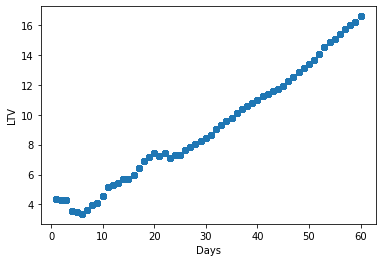

In [11]:
"""
Визуализируем как менялись значения LTV
"""
plt.scatter(all_data.day, all_data['ltv'])
plt.xlabel('Days')
plt.ylabel('LTV')

In [12]:
"""
Подберем значения коэффициентов для прогноза значения LTV на 180 день
"""

X = all_data.day.values 
Y = all_data['ltv'].values

coefs, cov = optimize.curve_fit(lambda t, a, b: a + b * np.log(t),  X,  Y)
def ltv_predict(param):
    return coefs[0] + coefs[1] * np.log(param)

all_data_fact_ltv = all_data.ltv.max()
ltv180 = ltv_predict(180)

print("Фактический LTV на 60 день: {:.2f} $".format(all_data_fact_ltv))
print("Прогнозируемый LTV на 180 день: {:.2f} $".format(ltv180))

Фактический LTV на 60 день: 16.59 $
Прогнозируемый LTV на 180 день: 18.99 $


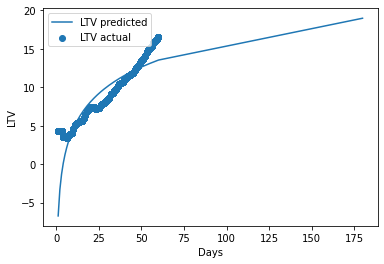

In [13]:
"""
Визуализируем оба графика -- фактические значения и преддиктивную кривую
"""

days = np.hstack([X, [60, 180]])
plt.scatter(X, Y)
plt.plot(days, ltv_predict(days.reshape(-1, 1)))
plt.xlabel('Days')
plt.ylabel('LTV')
plt.legend(['LTV predicted', 'LTV actual'])

# Сделаем аналогичные рассчеты для 3-х самых крупных источников траффика

In [14]:
users.groupby(['source', 'country']) \
    .agg({
        'user_id': 'count'
        }) \
    .sort_values('user_id', ascending=False) \
    .head(3)

,,user_id
source,country,
Facebook Ads,DE,30640
googleadwords_int,DE,22290
Facebook Ads,BR,14743


##  Видим что самые большие по количеству пользователей такие сочетания источника и страны 

- Facebook Ads + DE
- googleadwords_int + DE
- Facebook Ads + BR

Для них и рассчитаем данные

Назовем датасеты для выбранных стран и источников следующим образом:

- Facebook Ads + DE --> fb_de
- googleadwords_int + DE --> gads_de
- Facebook Ads + BR --> fb_br

## Так же зададим:
- функцию, которая будет расчитывать фактическое зачение LTV и преддиктивные значения на основании названия источника и страны --> **predict_ltv**
- функцию, которая отрисует фактическое распределение LTV по дням --> **fact_ltv_curv**
- функцию, которая отрисует график фактического распределения и преддиктивную кривую --> **predict_curv**

In [15]:
def predict_ltv(source_string, country_string):
    selected = data.copy()
    selected = selected[(selected['source'] == source_string) & (selected['country'] == country_string)]
    selected[['pay_date_datetime', 'reg_date_datetime']] = selected[['pay_date_datetime', 'reg_date_datetime']].apply(pd.to_datetime)
    selected = selected.sort_values('pay_date_datetime').reset_index()

    def cumulative(date):
        return selected['pay_amount'].where(selected['pay_date_datetime'] <= date).sum()
    selected['sum'] = selected['pay_date_datetime'].map(lambda x: cumulative(x))

    def users_count(date):
        return selected['user_id'].where(selected['reg_date_datetime'] <= date).count()
    selected['users_count'] = selected['pay_date_datetime'].map(lambda x: users_count(x))
    selected['ltv'] = selected['sum'] / selected['users_count'].astype(float)
    selected['day'] = pd.to_timedelta(selected['pay_date_datetime'] - selected['reg_date_datetime'].min()).dt.days + 1
    selected['day'] = selected['day'].astype(int)

    X = selected['day'].values 
    Y = selected['ltv'].values

    coefs, cov = optimize.curve_fit(lambda t, a, b: a + b * np.log(t),  X,  Y)
    def ltv_predict(param):
        return coefs[0] + coefs[1] * np.log(param)
    
    selected_fact_ltv = selected.ltv.max()
    selected_ltv60 = ltv_predict(60)
    selected_ltv180 = ltv_predict(180)
    print('Фактический LTV для ' + source_string + ' + ' + country_string + ' на 60 день: {:.2f} $'.format(selected_fact_ltv))
    print('Прогнозируемый LTV для ' + source_string + ' + ' + country_string + ' на 180 день: {:.2f} $'.format(selected_ltv180))
    return selected

In [16]:
def fact_ltv_curv(dataset):
    plt.scatter(dataset['day'], dataset['ltv'])
    plt.xlabel('Days')
    plt.ylabel('LTV')

In [17]:
def predict_curv(dataset):
    X = dataset['day'].values 
    Y = dataset['ltv'].values
    days = np.hstack([X, [60, 180]])
    plt.scatter(X, Y)
    plt.plot(days, ltv_predict(days.reshape(-1, 1)))
    plt.xlabel('Days')
    plt.ylabel('LTV')
    plt.legend(['LTV predicted', 'LTV actual'])

## Facebook Ads + DE

In [18]:
fb_de = predict_ltv('Facebook Ads', 'DE')

Фактический LTV для Facebook Ads + DE на 60 день: 12.62 $
Прогнозируемый LTV для Facebook Ads + DE на 180 день: 18.11 $


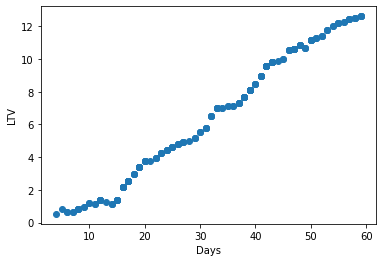

In [19]:
fb_de_curv = fact_ltv_curv(fb_de)

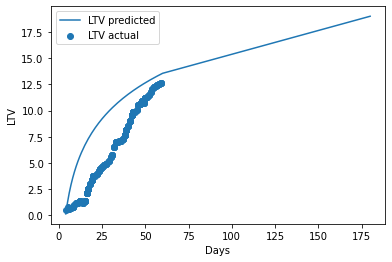

In [20]:
fb_de_predict_curv = predict_curv(fb_de)

## Goodle Ads + DE

In [21]:
gads_de = predict_ltv('googleadwords_int', 'DE')

Фактический LTV для googleadwords_int + DE на 60 день: 11.80 $
Прогнозируемый LTV для googleadwords_int + DE на 180 день: 14.54 $


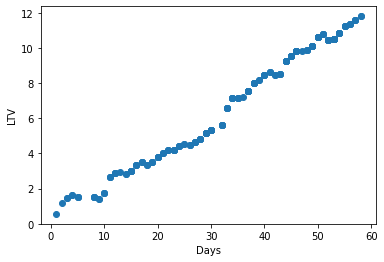

In [22]:
gads_de_curv = fact_ltv_curv(gads_de)

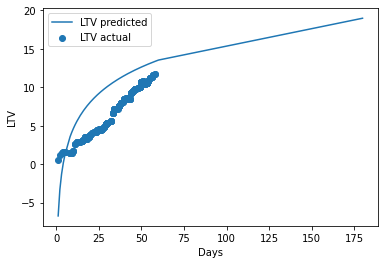

In [23]:
gads_de_predict_curv = predict_curv(gads_de)

## Facebook Ads + BR

In [24]:
fb_br = predict_ltv('Facebook Ads', 'BR')

Фактический LTV для Facebook Ads + BR на 60 день: 12.61 $
Прогнозируемый LTV для Facebook Ads + BR на 180 день: 17.06 $


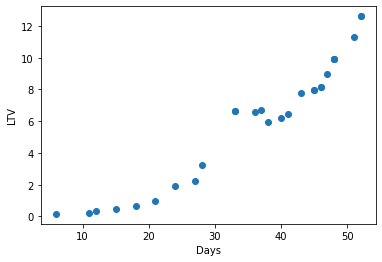

In [25]:
fb_br_curv = fact_ltv_curv(fb_br)

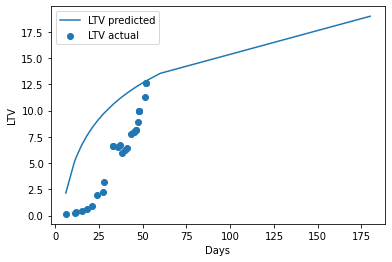

In [26]:
fb_br_predict_curv = predict_curv(fb_br)

# Выводы

1. Значение LTV на 60 день по всей выборке данных составило -- **16.69$**
2. Прогнозируемое значение LTV на 180 день по всей выборке данных составило -- **18.99$**
3. Из 3-х выбранных связок источник-город лучшим по фактическому значению LTV оказался Facebook Ads + DE со значением 12.62. Он же имеет на 180 день больший LTV = 18.11
4. Заметно, что в источниках не фигурировал органический трафик. Ниже я так же рассчитала значения 60/180 для органического и не органического трафика. Результаты такие 
    - органический трафик: 60 день -- 18.06$ ; 180 день -- 20.17$
    - не органический трафик: 60 день -- 16.29$ ; 180 день -- 18.98$
    > Закономерно, то трафик, который нашел игру органически более лояльный и готов тратить больше
5. Имея значения стоимости привлечения клиента можно было бы посчитать окупаемость каждого источника трафика -- это позволит при необходимости перераспределить ресурсы на рекламу отключив трафик, который окупается очень долго или совсем не окупается и выделить больше ресурсов на быстро окупаемый трафик 
6. Значение можно сравнить с бенчмарками по рынку чтобы понимать в целом уровень лояльности и привлекательности
7. Значение можно пересчитать на когорты пользователей по месяцам имея бОльшую выборку данных -- например последний год-два. Это позволит отследить общую тенденцию на увеличение или уменьшение LTV за последнее время, так же это покажет возможную сезонность или рост от проводимых маркетинговых кампаний. 
8. Зная LTV можно пойти дальше и сегментировать пользователей на:
    - группы типа "LTV выше среднего" / "LTV средний" / "LTV ниже среднего" и например у первой (самой лучшей) группы посмотреть треки поведения в игре, возможно определенная последовательность прохождения или открытие дополнительных опций делает их более лояльными 
    - возраст пользователей 
    - пол
    - страна / регион

In [29]:
def predict():
    selected = data.copy()
    # selected = selected[selected['source'] != 'ORGANIC'] # for not organic
    selected = selected[selected['source'] == 'ORGANIC'] # fot organic
    selected[['pay_date_datetime', 'reg_date_datetime']] = selected[['pay_date_datetime', 'reg_date_datetime']].apply(pd.to_datetime)
    selected = selected.sort_values('pay_date_datetime').reset_index()

    def cumulative(date):
        return selected['pay_amount'].where(selected['pay_date_datetime'] <= date).sum()
    selected['sum'] = selected['pay_date_datetime'].map(lambda x: cumulative(x))

    def users_count(date):
        return selected['user_id'].where(selected['reg_date_datetime'] <= date).count()
    selected['users_count'] = selected['pay_date_datetime'].map(lambda x: users_count(x))
    selected['ltv'] = selected['sum'] / selected['users_count'].astype(float)
    selected['day'] = pd.to_timedelta(selected['pay_date_datetime'] - selected['reg_date_datetime'].min()).dt.days + 1
    selected['day'] = selected['day'].astype(int)

    X = selected['day'].values 
    Y = selected['ltv'].values

    coefs, cov = optimize.curve_fit(lambda t, a, b: a + b * np.log(t),  X,  Y)
    def ltv_predict(param):
        return coefs[0] + coefs[1] * np.log(param)
    
    selected_fact_ltv = selected.ltv.max()
    selected_ltv180 = ltv_predict(180)
    print('Фактический LTV на 60 день: {:.2f}'.format(selected_fact_ltv))
    print('Прогнозируемый LTV на 180 день: {:.2f}'.format(selected_ltv180))
    return selected

In [30]:
organic = predict()

Фактический LTV на 60 день: 18.06
Прогнозируемый LTV на 180 день: 20.17


In [28]:
not_organic = predict()

Фактический LTV на 60 день: 16.29
Прогнозируемый LTV на 180 день: 18.98
